# Topic Modelling Overview

*This notebook provides an overview of various models and techniques commonly used in [topic modelling](https://en.wikipedia.org/wiki/Vector_space_model).* We will be using the [`sklearn`](https://en.wikipedia.org/wiki/Vector_space_model) library to demonstrate the techniques and models discussed, though they are also present in other libraries like [`gensim`](https://en.wikipedia.org/wiki/Vector_space_model).

> **Author's note**: This notebook contains everything I've learnt while undertaking my GCRL2000 placement. I've tried rephrasing the information in a digestable form (to me at least) but do note that some information may be inaccurate or wrongly interpreted (don't sue me). Hope this is useful :D
>
> 	-Tin Chi Pang (23301921)

**Run the code cell below before you proceed!**

In [1]:
from nlp import plot_document_matrix, preprocess_df, print_topics, \
    graph_topic_terms_matrix
import pandas as pd

# Enable interactive 3D graph
%matplotlib widget


example_corpus = ["dog bites man", "man bites dog", 
                  "dog bites meat and dog eats meat"]

news_df = pd.read_csv("./dataset/abcnews-date-text.csv", nrows=10000)
news_df_cleaned = preprocess_df(news_df, "headline_text")
news_corpus = news_df_cleaned['headline_text']


def print_matrix(pretext, matrix):
    print(pretext)
    for i in range(matrix.shape[0]):
        print(f'Document {i}:\t[', end='')
        for j in range(matrix.shape[1]):
            print(f'{matrix[i, j]:.3f}', end='')
            if j + 1 != matrix.shape[1]:
                print(f',\t', end='')
        print(']')

---

## Overview
- [Introduction - What is Topic Modelling?](#introduction)
    - [Key Definitions](#definitions)
    - [What is a "Topic"?](#topic)
- [Vectorisation](#vectorisation)
    - [Vector Space Model](#vector-space)
    - [Document-Term Matrix](#document-term)
    - [Vectorisation Techniques](#vectorisation-techniques)
        - [Bag-of-Word (BoW)](#bow)
        - [Bag-of-$n$-Grams](#bog)
        - [TF-IDF](#tfidf)
- [Topic Models](#models)
    - [Latent Dirichlet Allocation (LDA)](#lda)
    - [Non-Negative Matrix Factorisation (NMF)](#nmf)
- [Dimensionality Reduction](#dimensionality-reduction)
    - [Principal Component Analysis (PCA)](#pca)
    - [t-SNE](#tsne)

---

<a id="introduction"></a>
## 1. Introduction - What is Topic Modelling?
> **Topic modelling** is a subfield of **Natural Language Processing** (NLP) concerned with finding abstract *topics* in a collection of documents.

<a id="definitions"></a>
### Key Definitions
| Key term   | Definition                                                                                                |
| ---------- | --------------------------------------------------------------------------------------------------------- |
| Document   | A single text; e.g. a sentence, tweet, essay, or a Wikipedia article.                                     |
| Corpus     | A collection of documents.                                                                                |
| Term       | Individual words or phrases in the vocabulary.                                                            |
| Vocabulary | A set of all relevant terms throughout the entire corpus (excludes stop words and other irrelevant terms) |



<a id="topic"></a>
### What is a "Topic"?
A **topic** is a set of words, that together suggest a shared theme. For example, consider the following set:
$$
\set{\text{human, nucleus, DNA, codon, adenine, cell}}
$$
We can infer that the topic may be "genetics", or "human biology" etc. - note that we must interpret and assign the actual topic manually by looking at the words. Often we may need to look into the documents themselves to gain a better insight on what the actual topic is.

A topic can also be described as a *probability distribution* over the vocabulary. Say that we have some documents about "photosynthesis" and some documents about the "effect of chocolate on pets" in our corpus. We've removed all stop words like "the" but forgot to remove the word "and".
$$
 \text{vocab} = \set{\text{dog, chloroplast, photosynthesis, cat, leaf, glucose, chocolate, and}}
$$
Intuitively we know that a document about "photosynthesis" will have more occurrence of terms like "leaf" or "chloroplast" - hence we may have a probability distribution like this for that topic:

![](attachments/1.png)


We can then define topic as the set of terms from the vocabulary with high probability of occuring. In that case, the topic "photosynthesis" will be the set:
$$
 \text{photosynthesis}_\text{topic} = \set{\text{chloroplast, photosynthesis, leaf, glucose}}
$$

Topic modelling is thus about finding these hidden sets of words with shared theme within a given corpus.

---

<a id="vectorisation"></a>
## 2. Vectorisation
Before applying Machine Learning and statistical models onto the textual data, we must first convert them to numerical representations. For example, image data is often represented as a matrix of numbers, where each number represents the RGB value of a pixel in the image. Unfortunately, texts are a little more complicated than other forms of data to convert.

<a id="vector-space"></a>
### Vector Space Model
The [**vector space model**](https://en.wikipedia.org/wiki/Vector_space_model) is an algebraic model for representing texts, where documents are represented as a vector (list) of numbers (hence the name *vectorisation*). This number can simply be the number of times a term has occured in said document, or some other metric. 

Typically, each term in the vocabulary is assigned an ID. The $i$-th number in a vector is the numerical representation for the $i$-th term in the dictionary (please see the [Bag-of-Word section](#bow) for an example).

This way, each document can be thought of as a point in a $n$-dimensional [vector space](https://en.wikipedia.org/wiki/Vector_space) where $n$ is the number of terms in the vocabulary. Documents with similar terms will be closer in the vector space than other documents with different terms.

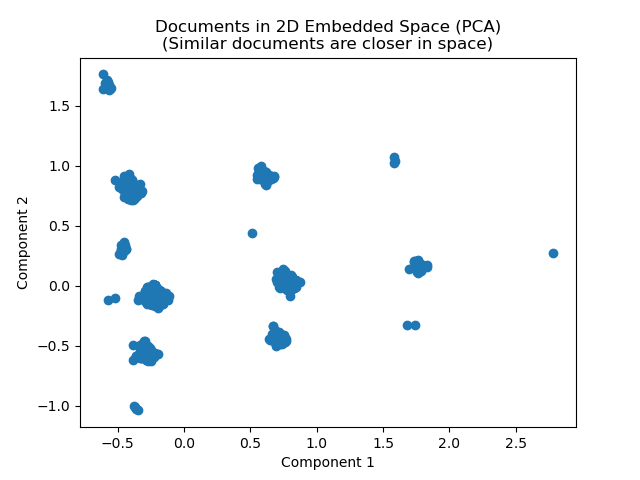

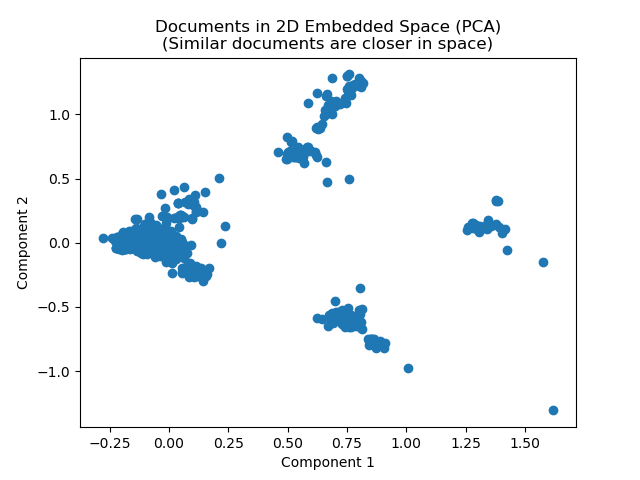

In [2]:
# Show documents in vector space, clusters indicate documents with similar terms
from sklearn.feature_extraction.text import CountVectorizer
from nlp import plot_document_matrix, preprocess_df
import pandas as pd

# Using BoW
vectoriser = CountVectorizer()

# Plot documents in vector space before pre-processing
doc_term_matrix = vectoriser.fit_transform(news_df["headline_text"])
plot_document_matrix(doc_term_matrix, n_samples=5000)

# Plot documents again after pre-processing
doc_term_matrix = vectoriser.fit_transform(news_df_cleaned["headline_text"])
plot_document_matrix(doc_term_matrix, n_samples=5000)

<a id="document-term"></a>
### Document-Term Matrix
A **document-term matrix** for a corpus of $m$ documents and vocabulary of size $n$, is a $m \times n$ matrix (left). each number in the matrix is the numeric representation for a term in a document. This is just a convenient way of representing a list of document vectors (right).
$$\text{document-term matrix} = \begin{Bmatrix} 
& w_1 & w_2 & \dots & w_n\\
D_1 & \dots & \dots & \dots & \dots \\
D_2 & \dots & \dots & \dots & \dots \\
D_3 & \dots & \dots & \dots & \dots \\
& & \vdots \\
D_m & \dots & \dots & \dots & \dots 
\end{Bmatrix}\ \  \equiv \ \ 
\begin{matrix}
D_1 = [\dots,\  \dots,\  \dots, \ \dots] \\
D_2 = [\dots,\  \dots,\  \dots, \ \dots] \\
D_3 = [\dots,\  \dots,\  \dots, \ \dots] \\
\vdots \\
D_m = [\dots,\  \dots,\  \dots, \ \dots] \\
\end{matrix}
$$


<a id="vectorisation-techniques"></a>
### Vectorisation Techniques

<a id="bow"></a>
#### Bag-of-Word (BoW)
The [Bag-of-Word model](https://en.wikipedia.org/wiki/Bag-of-words_model) represent each document as a list of frequency counts for each term in the vocabulary.

- Formally...
	- Given a vocabulary $V$ (with $|V|$ denoting the number of terms in $V$) with each term in it assigned a unique ID
	- a document $d_j$ is a vector of size $|V|$ that stores the number of times a term in $V$ occured in $d_j$

For example, consider the following corpus:
| Document | Text           |
| -------- | -------------- |
| D1       | dog bites man |
| D2       | man bites dog |
| D3       | dog bites meat and dog eats meat|
- $V = \set{\text{dog, bites, man, eats, meat, and}}$
	- each term is assigned an ID ranging from 1 to 6
- Then, D1 can be represented as a 6D vector where the $i$-th number represent how many times the $i$-th term in $V$ occured in D1:
$$\text{D1} = [1, 1, 1, 0, 0, 0]$$
- Applying this to all documents, we end up with the following document-term matrix:
$$
\begin{matrix}
V & =& \{\text{dog}, & \text{bites}, &  \text{man},& \text{eats}, & \text{meat}, &  \text{and}\} \\
\text{ID} & =& \{1,& 2,& 3,& 4,& 5,& 6\} \\
\\
D_1 & =& [1,& 1,& 1,& 0,& 0,&  0] \\
D_2 & =& [1,& 1,& 1,& 0,& 0,& 0] \\
D_3 & =& [2,& 1,& 0,& 1,& 1,& 1] \\
\end{matrix}
$$


In [3]:
# BoW in sklearn
# User guide:
#   https://scikit-learn.org/stable/modules/feature_extraction.html#the-bag-of-words-representation
# Documentation:
#   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

vectoriser = CountVectorizer()
doc_term_matrix = vectoriser.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {vectoriser.get_feature_names_out()}')
print_matrix("Document-terms matrix (BoW):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and' 'bites' 'dog' 'eats' 'man' 'meat']
Document-terms matrix (BoW):
Document 0:	[0.000,	1.000,	1.000,	0.000,	1.000,	0.000]
Document 1:	[0.000,	1.000,	1.000,	0.000,	1.000,	0.000]
Document 2:	[1.000,	1.000,	2.000,	1.000,	0.000,	2.000]


<a id="bog"></a>
#### Bag-of-$n$-Grams
The bag-of-$n$-grams model is the exact same as BoW, differing in only that each term in the vocabulary can consist of more than one word. These phrases consisting of $n$ words are called [$n$-grams](https://en.wikipedia.org/wiki/N-gram). For example, "dog", "cat", "chocolate" are 1-grams (AKA *unigrams*), "red dog", "black cat", "white chocolate" are 2-grams (AKA *bigrams*) and so forth. This captures word-order to some degree.

In [4]:
# Bag-of-n-grams in sklearn
from sklearn.feature_extraction.text import CountVectorizer

vectoriser = CountVectorizer(ngram_range=(2, 2))
doc_term_matrix = vectoriser.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {vectoriser.get_feature_names_out()}')
print_matrix("Document-terms matrix (BoG):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and dog' 'bites dog' 'bites man' 'bites meat' 'dog bites' 'dog eats'
 'eats meat' 'man bites' 'meat and']
Document-terms matrix (BoG):
Document 0:	[0.000,	0.000,	1.000,	0.000,	1.000,	0.000,	0.000,	0.000,	0.000]
Document 1:	[0.000,	1.000,	0.000,	0.000,	0.000,	0.000,	0.000,	1.000,	0.000]
Document 2:	[1.000,	0.000,	0.000,	1.000,	1.000,	1.000,	1.000,	0.000,	1.000]


<a id="tfidf"></a>
#### TF-IDF
Stands for "*Term Frequency-Inverse-Document-Frequency*", [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) uses a weighting that reflects how important a term is to a document (as opposed to merely being a frequency count like in BoW). This TF-IDF weight value is high if a term only occurs in a small number of documents, with the idea that rarer terms like "scoliosis" are more likely to be meaningful as opposed to more commonly-used terms like "medical". 

For some term $t$ and some document $d$ in corpus $D$, the TF-IDF score is calculated as the product of TF and IDF:
$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \cdot \text{idf}(t, D)$$
$$\text{tf}(t, d) = \frac{\text{number of times }t \text{ occured in }d}{\text{total frequencies of terms in }d} = \frac{\text{count}(t, d)}{\sum\limits_{t' \in d} \text{count}(t', d)}$$
$$
\text{idf}(t, D) = \log \frac{\text{number of documents}}{\text{number of documents that } t \text{ occurs in}} = \frac{|D|}{|\set{d \in D: t \in d}|}
$$


In [5]:
# TF-IDF in sklearn
# User guide:
#   https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
# Documentation
#   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp import plot_document_matrix
import matplotlib.pyplot as plt

vectoriser = TfidfVectorizer()
doc_term_matrix = vectoriser.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {vectoriser.get_feature_names_out()}')
print_matrix("Document-terms matrix (TF-IDF):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and' 'bites' 'dog' 'eats' 'man' 'meat']
Document-terms matrix (TF-IDF):
Document 0:	[0.000,	0.523,	0.523,	0.000,	0.673,	0.000]
Document 1:	[0.000,	0.523,	0.523,	0.000,	0.673,	0.000]
Document 2:	[0.359,	0.212,	0.424,	0.359,	0.000,	0.719]


---

<a id="models"></a>
## 3. Topic Models
After vectorising the textual data, various models can then be applied on the resulting document-term matrix to possibly discover the topics in the corpus (often using unsupervised learning). Unfortunately the number of topics must be specified, and the hyperparameters of the model must be tuned experimentally to find interpretable topics from the data.

<a id="lda"></a>
### Latent Dirichlet Allocation (LDA)
[LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is the most commonly used statistical model in topic modelling, where topics are described as *probability distribution* over the vocabulary (see ['What is a "Topic"?'](#topic)).

LDA works by assuming that documents is a mixture of topics and can be *generated* by the following steps:
1. Choose how many terms to write into the document
2. Select the mixture of topics that this document should cover (e.g. 40% topic X, 60% topic Y, 0% topic Z)
3. Then, to write each term into the document...

	4. Choose a topic from the mixture (e.g. we chose topic X with 40% chance)
	5. Choose a term from that selected topic - this is the term we will write into the document (e.g. say, we chose the term "cat" have 15% chance of occuring in topic X)

LDA will attempt to reverse this process starting from the already-written documents to identify the hidden topics ("latent"). Say we have 3 topics, and we plot them on a 2D graph. Each document is then allocated onto the graph with the position indicating how much of the document is of specific topic.

![](attachments/2.png)

Given a document-term matrix $M$ of shape $(m, n)$ and specifying $k$ topics, LDA will factorise it into 2 submatrices which can be used to understand the topic structure of the corpus.
- $M_1$ = *document-topic matrix*, dimension $(m, k)$ 
- $M_2$ = *topic-term matrix*, dimension $(k, n)$
For example, say we have $M$ = 

![](attachments/3.png)

$M_1$ and $M_2$ respectively =

![](attachments/4.png)

> **Author's note**: I don't know the specifics on how LDA reverses the steps, I just know it produces 2 matrices


In [6]:
# LDA in sklearn, using BoW document-term matrix
# User guide:
#   https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn-decomposition-latentdirichletallocation
# Documentation:
#   https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 6    # Play around with this value to see different results!

vectoriser = CountVectorizer()
doc_term_matrix = vectoriser.fit_transform(news_corpus)

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50)
doc_topic_matrix = lda.fit_transform(doc_term_matrix)
topic_term_matrix = lda.components_

Top 10 words for topic #0:
['war', 'anti', 'call', 'protest', 'plan', 'green', 'health', 'may', 'support', 'protester']


Top 10 words for topic #1:
['iraq', 'war', 'iraqi', 'say', 'kill', 'un', 'force', 'baghdad', 'north', 'missile']


Top 10 words for topic #2:
['troop', 'hospital', 'death', 'govt', 'car', 'plan', 'report', 'toll', 'take', 'crash']


Top 10 words for topic #3:
['police', 'man', 'charge', 'court', 'face', 'miss', 'murder', 'probe', 'arrest', 'say']


Top 10 words for topic #4:
['new', 'water', 'rain', 'plan', 'council', 'set', 'drought', 'govt', 'fund', 'job']


Top 10 words for topic #5:
['win', 'world', 'cup', 'lead', 'pm', 'pay', 'nsw', 'road', 'race', 'election']




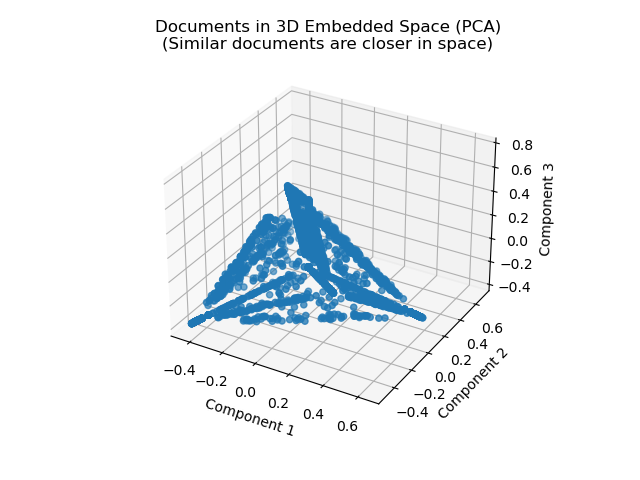

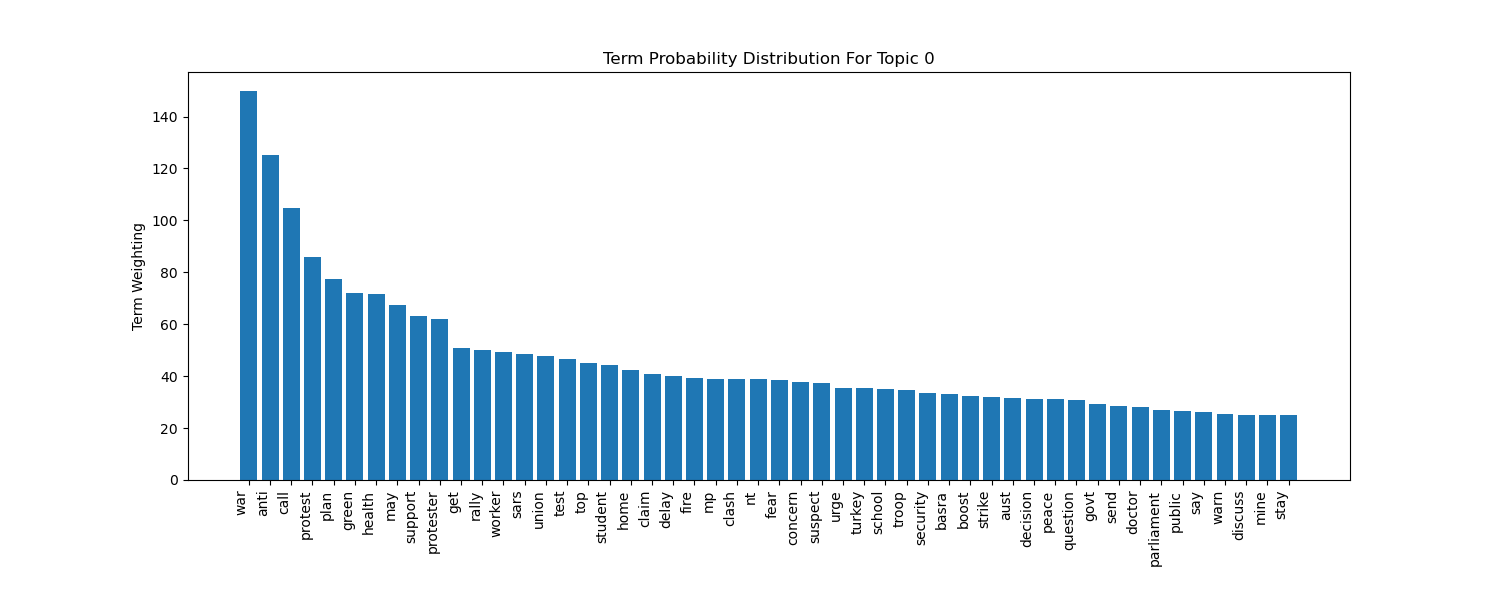

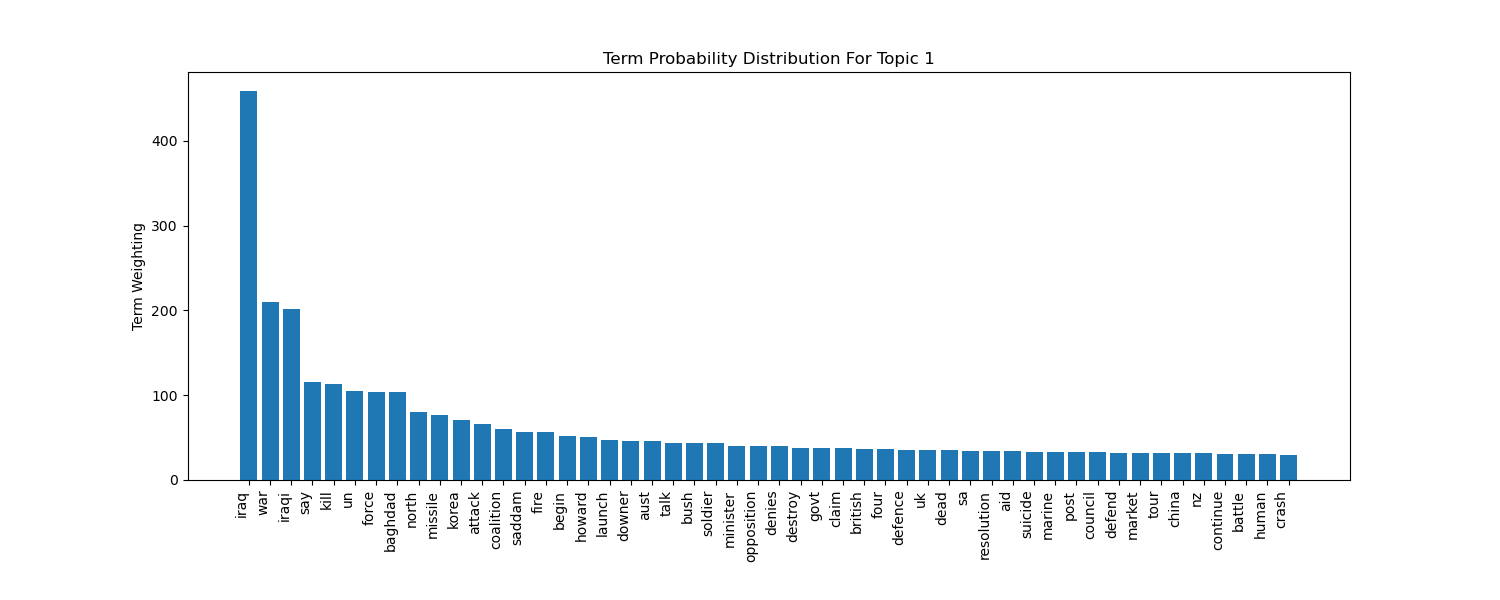

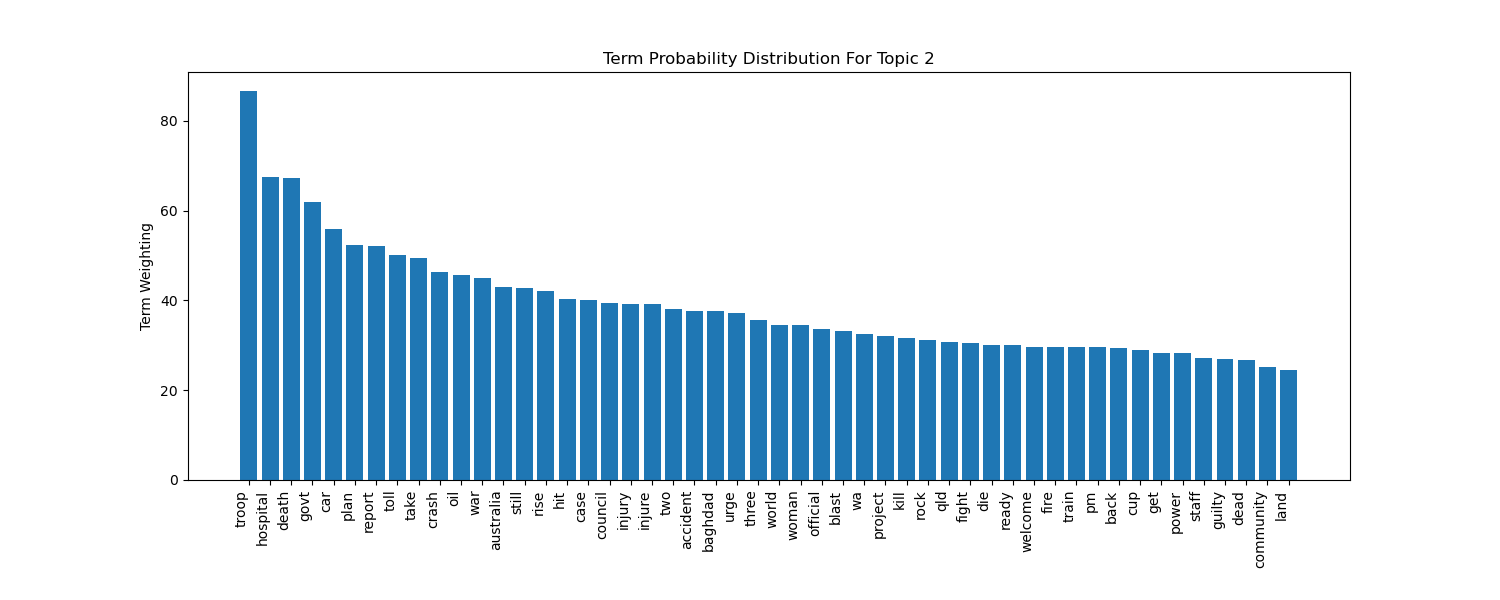

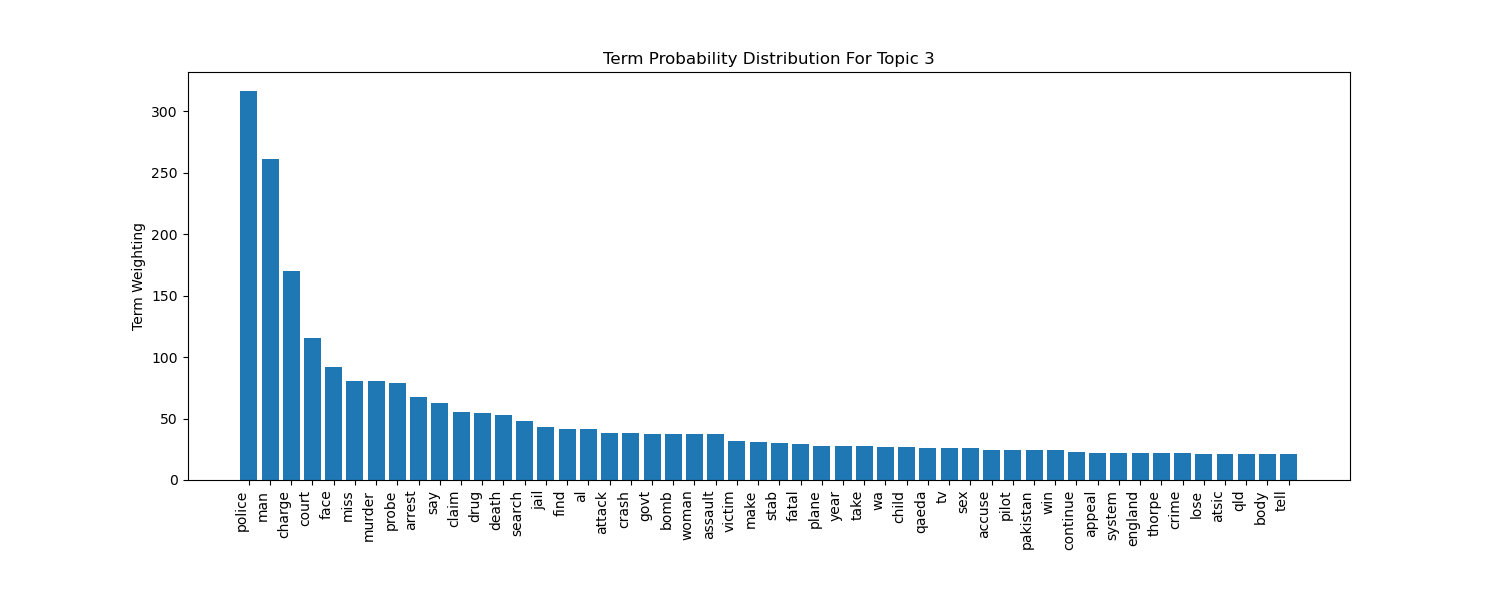

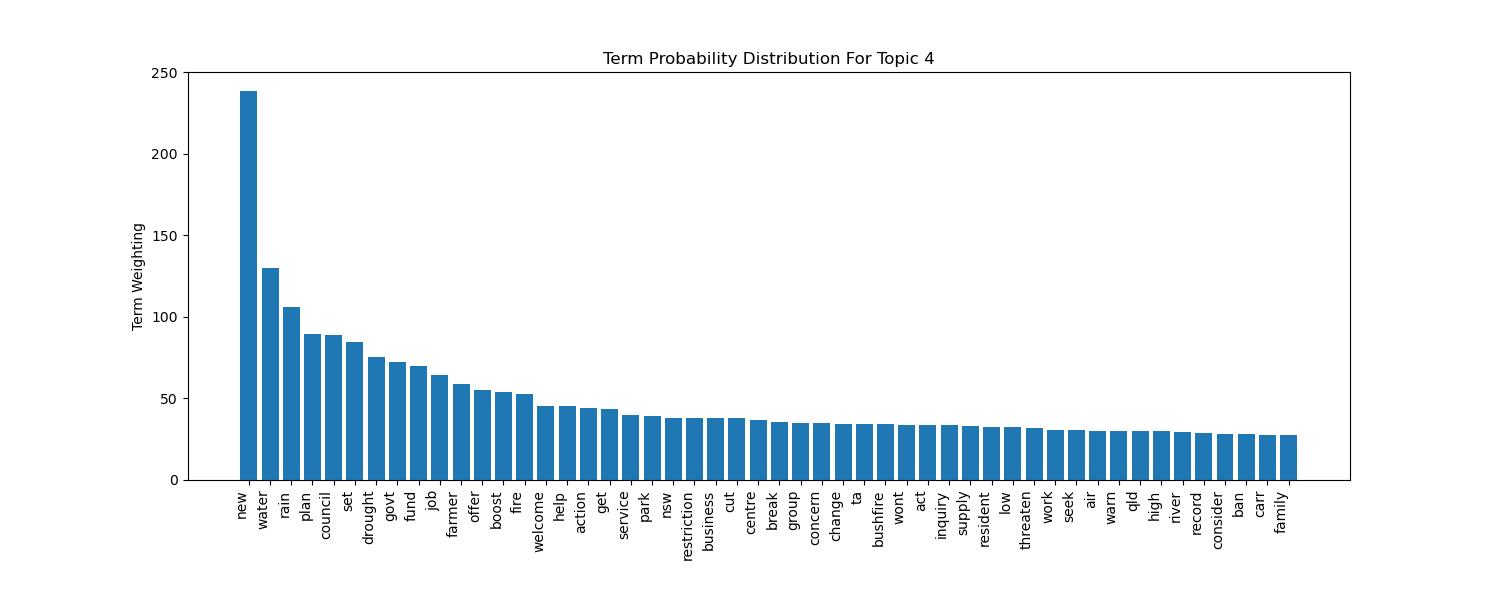

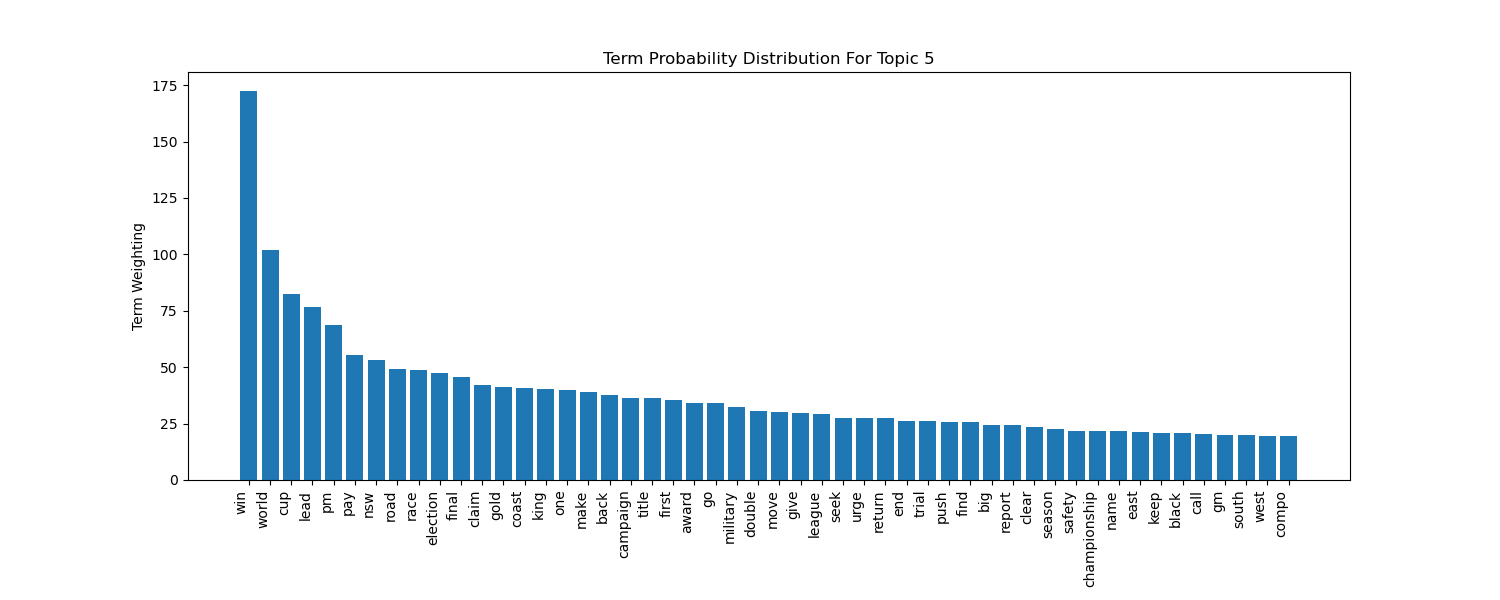

In [7]:
# Visualise each document with regards to their topic mixture
plot_document_matrix(doc_topic_matrix, dimension=3)

print_topics(lda, vectoriser, 10)

# Display probability distribution over vocabulary for each topic
for i in range(n_topics):
    graph_topic_terms_matrix(
        topic_term_matrix, vectoriser.get_feature_names_out(), i, max_words=50
    )

<a id="nmf"></a>
### Non-Negative Matrix Factorisation (NMF)

---

<a id="dimensionality-reduction"></a>
## 4. Dimensionality Reduction
During analysis, if we have $n$ terms in our vocabulary, then each document is represented as a $n$-dimensional vector. Often than not $n$ will be an incredibly large number, making it difficult to plot and visualise the individual document in the vector space. Hence, we must use [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) techniques to reduce the dimensions without altering the underlying structure of the data.

<a id="pca"></a>
### Principal Component Analysis (PCA)

<a id="tsne"></a>
### t-SNE